# Auto Regressive Models

## Imports

### Sys and Ipython

In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Graphics

In [2]:
%matplotlib inline

import geopandas as gpd
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from __init__ import *

### Scikit-Learn

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Source files 

In [31]:
%load_ext autoreload

%autoreload 2

from appendix_figures import (baseline_plot_results, plot_diff_along_time,
                              plot_qualitative_analysis, clustering_mape_map,
                              clustering_mape_line, ar_against_baseline)
from AR import AR
from Baseline import Baseline
from constant import data_matrix_15m_complete, dict_w, subway_stations
from metrics import mape_stations
from preprocessing import (del_split_norm, sub_bsline_s, add_bsline_s, 
                           sub_bsline_sj, add_bsline_sj, denormalize_T,
                           normalize_panel_data)
from Regressor import Regressor
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

### Contour Iris

In [5]:
contour_iris = gpd.read_file(
    '../datasets/iris/iris.shp')

convert_to_int = ['dep', 'insee_com', 'iris', 'code_iris']
for col in convert_to_int:
    contour_iris[col] = contour_iris[col].astype(int)

contour_iris = contour_iris[['code_iris', 'geometry', 'dep']]
contour_iris.head();

### Stations and Dates

In [6]:
station_data = pd.read_csv("../datasets/station_to_iris.csv")
station_data.describe();

### Transport Data

In [7]:
X_train, X_test, Xn_train, Xn_test, X_min_max = del_split_norm(
    dict_w, test_size=14, diff_days=7)

## Baseline Models

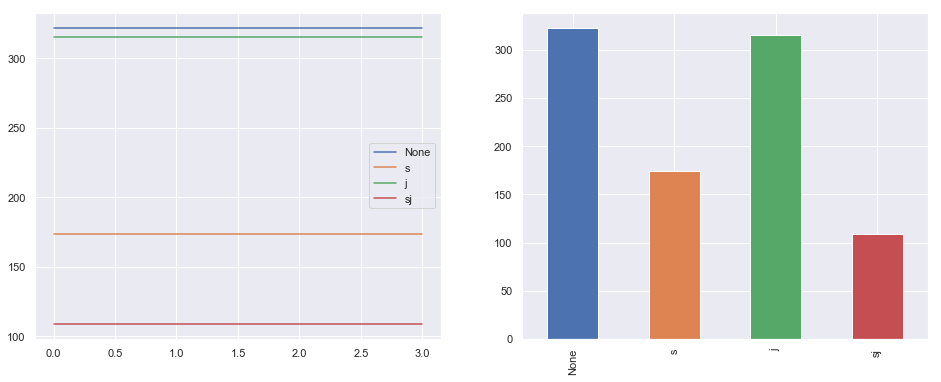

In [8]:
levels = ["None", "s", "j", "sj"]
df_baseline_scores, baseline_preds = baseline_plot_results(levels, X_train, X_test,
                                                           first_ndays=7)

## Auto Regressive Model

In [20]:
def fit_predict(ar_model, ar_limit_t, Xn_train, Xn_test, X_min_max):
    
    ar_model.fit(Xn_train)
    T = list(ar_model.forecast(Xn_test, tplus=ar_limit_t).values())
    ar_preds = denormalize_T(T, X_min_max) 
    
    return ar_preds

In [60]:
ar_order, ar_limit_t = 8, 8
linear_reg = LinearRegression(fit_intercept=True)
ar_model = AR(p=ar_order, model=linear_reg)
ar_preds = fit_predict(ar_model, ar_limit_t, Xn_train, Xn_test, X_min_max)
ar_scores = ar_model.score(X_test, ar_preds)

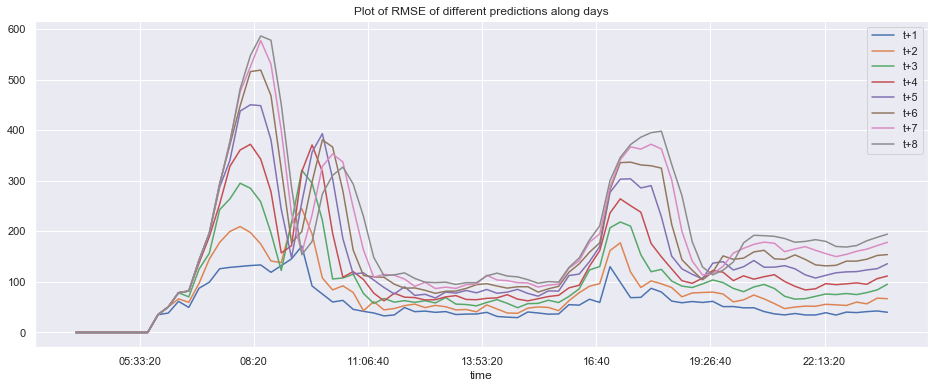

In [61]:
plot_diff_along_time(X_test, ar_preds)

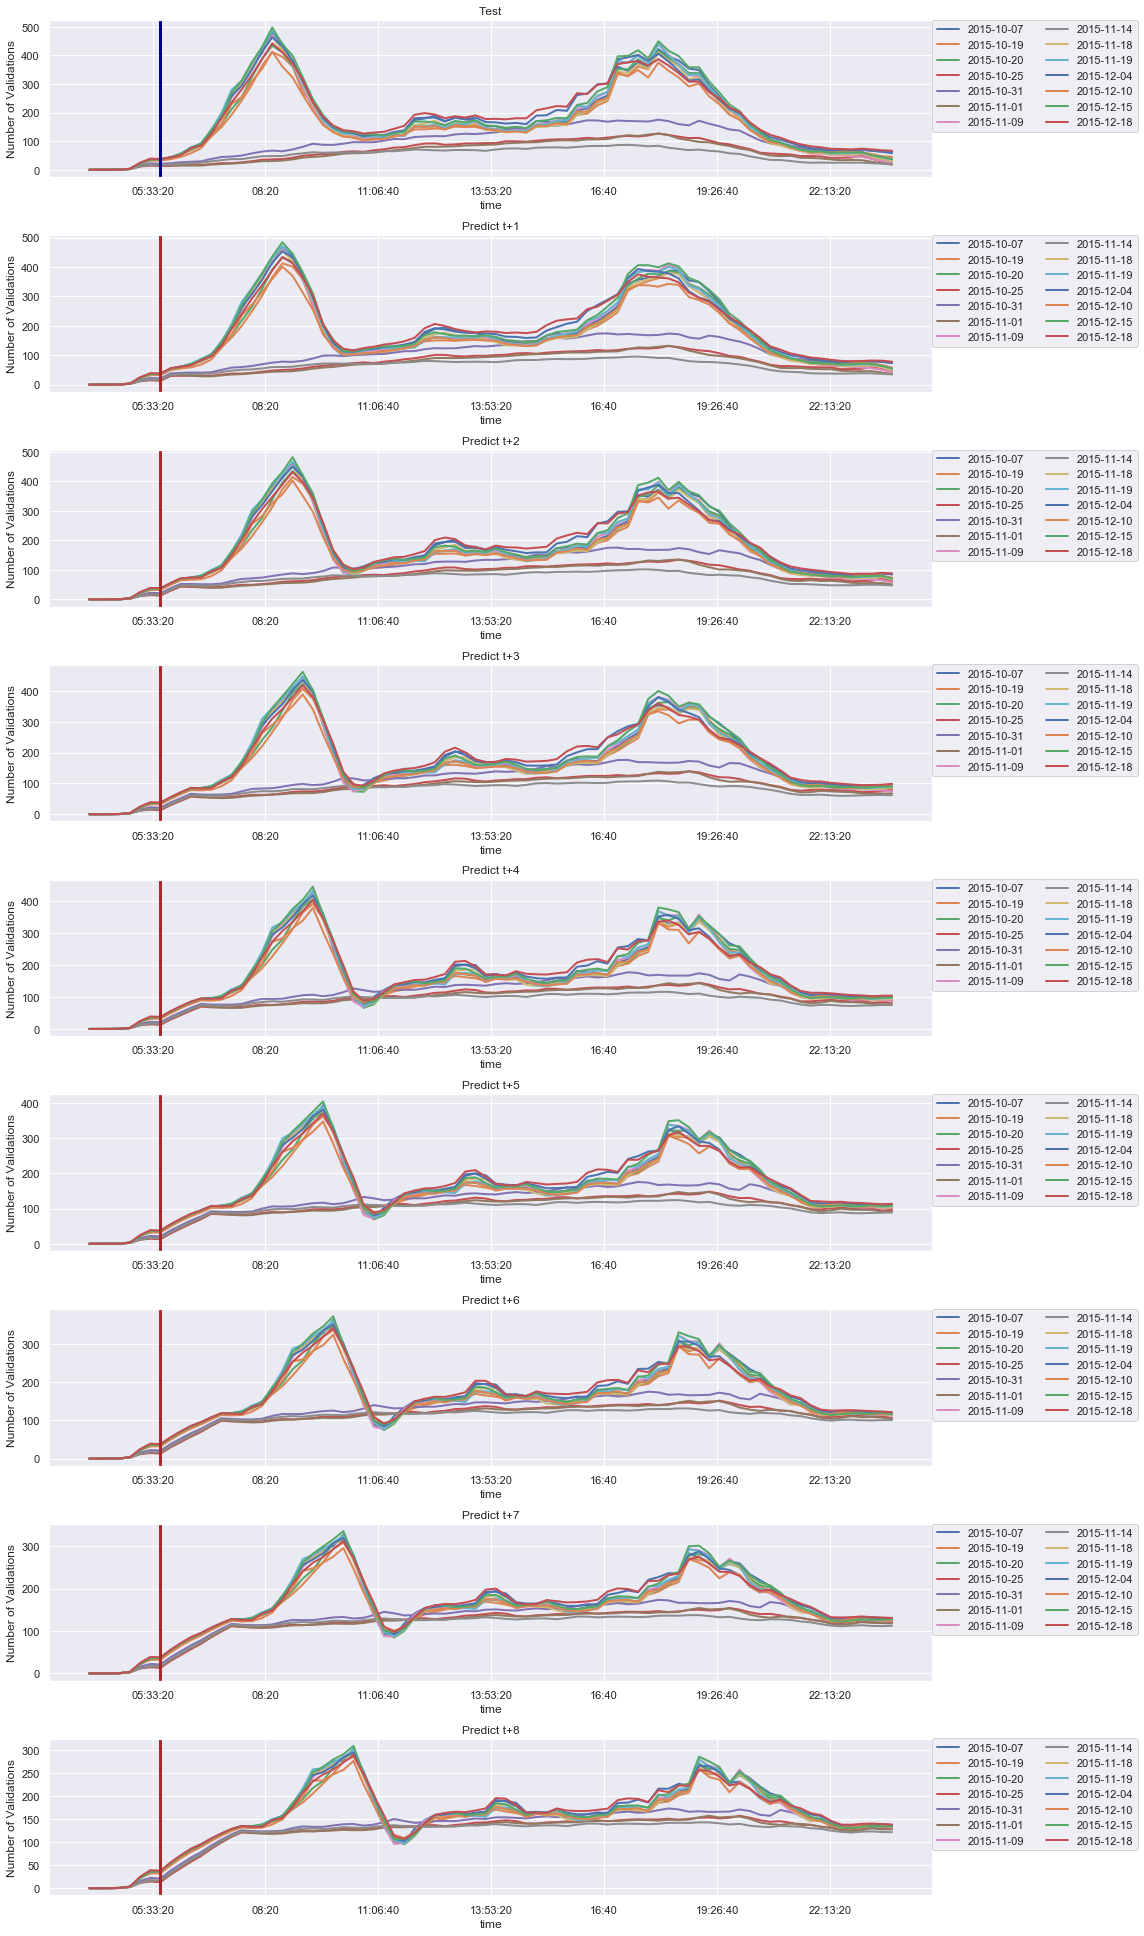

In [62]:
plot_qualitative_analysis(X_test, ar_preds, p=ar_order)

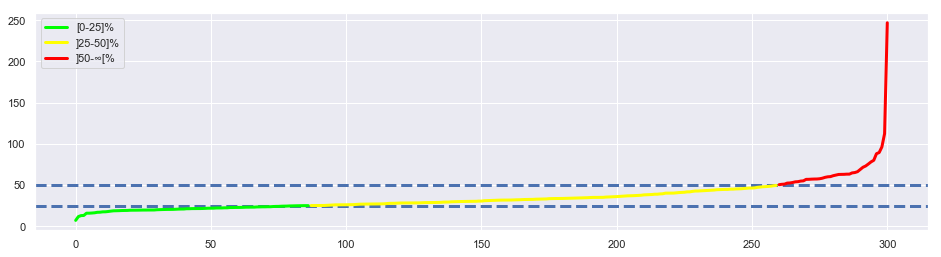

In [63]:
mape_firstt = mape_stations(X_test, ar_preds[0], p=ar_order)
clustering_mape_line(dict(zip(subway_stations, mape_firstt)), intervals=[25,50])

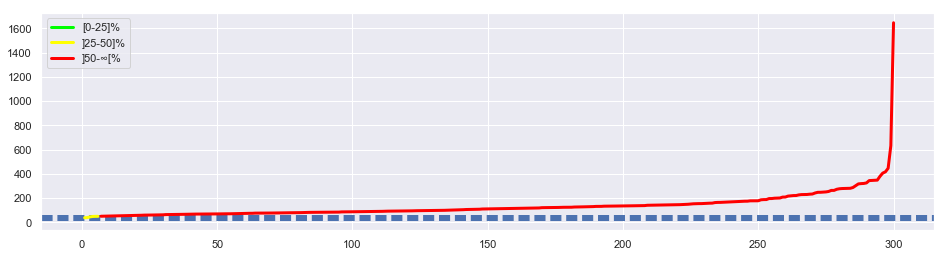

In [64]:
mape_lastt = mape_stations(X_test, ar_preds[-1], p=ar_order)
clustering_mape_line(dict(zip(subway_stations, mape_lastt)), intervals=[25, 50])

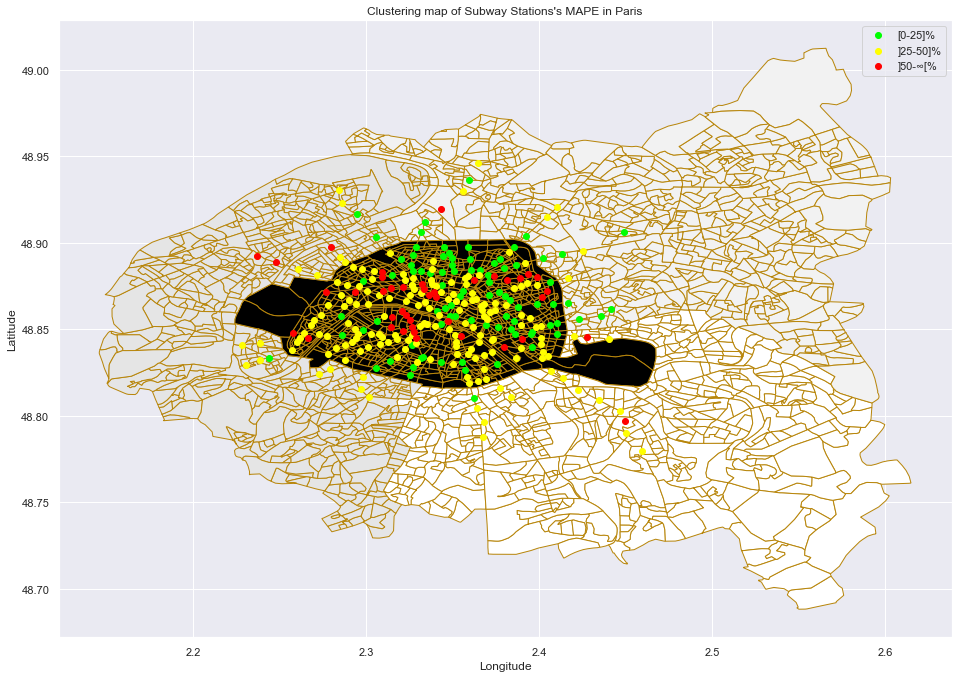

In [65]:
clustering_mape_map(contour_iris, station_data, dict(zip(subway_stations, mape_firstt)), 
                    intervals=[25, 50])

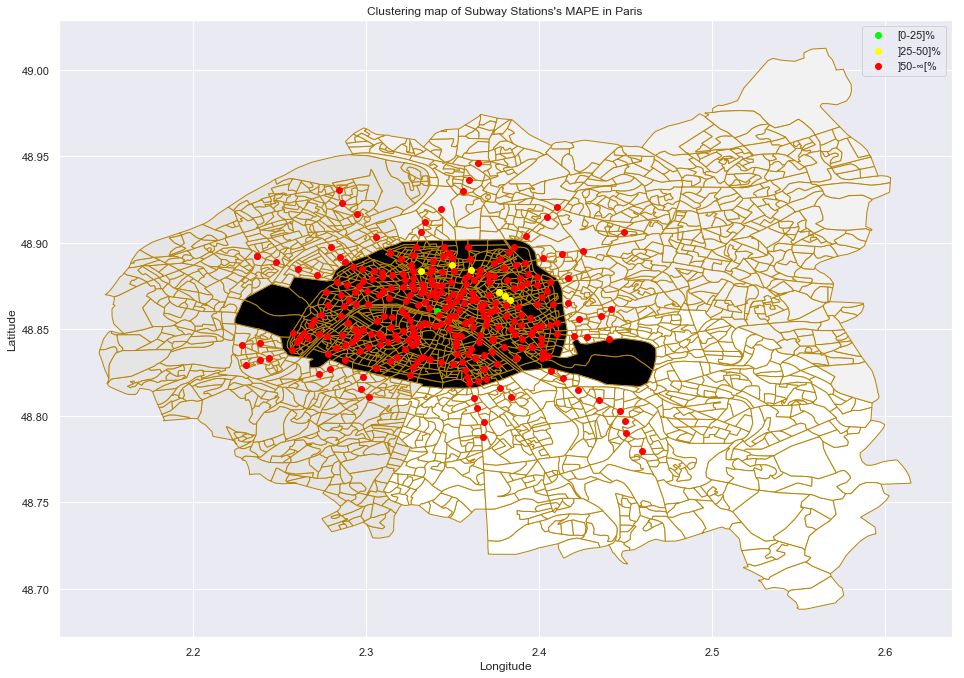

In [66]:
clustering_mape_map(contour_iris, station_data, dict(zip(subway_stations, mape_lastt)), 
                    intervals=[25, 50])

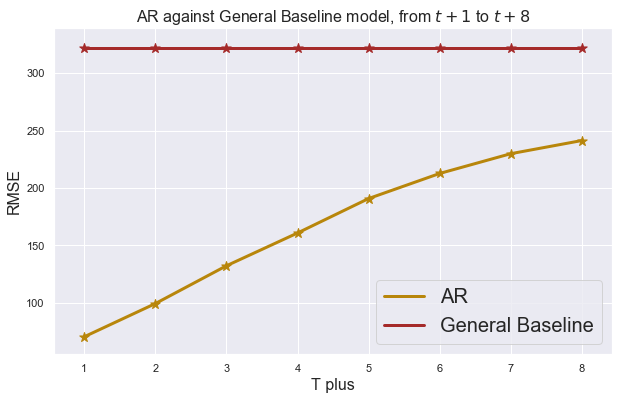

In [67]:
ar_against_baseline(ar_scores, df_baseline_scores.loc['RMSE', 'None'],
                   labels=['AR', 'General Baseline'],
                   title='AR against General Baseline model')

## Auto Regressive Model with Baseline

### Baseline per Station

In [68]:
Xbs_train = sub_bsline_s(X_train, baseline_preds[1])
Xbs_test = sub_bsline_s(X_test, baseline_preds[1])

Xbsn_train, Xbsn_test, Xbs_min_max = normalize_panel_data(Xbs_train, Xbs_test)

In [79]:
arbs_order, arbs_limit_t = 8, 8
arbs_reg = LinearRegression(fit_intercept=True)
arbs_model = AR(p=arbs_order, model=arbs_reg)

arbs_preds = fit_predict(arbs_model, arbs_limit_t, Xbsn_train, Xbsn_test, Xbs_min_max)

for t in range(arbs_limit_t):
    arbs_preds[t] = add_bsline_s(arbs_preds[t], baseline_preds[1])
    
arbs_scores = arbs_model.score(X_test, arbs_preds)

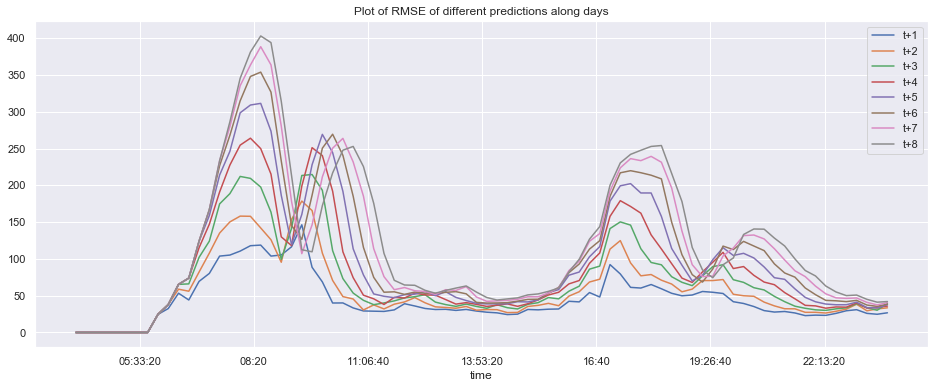

In [80]:
plot_diff_along_time(X_test, arbs_preds)

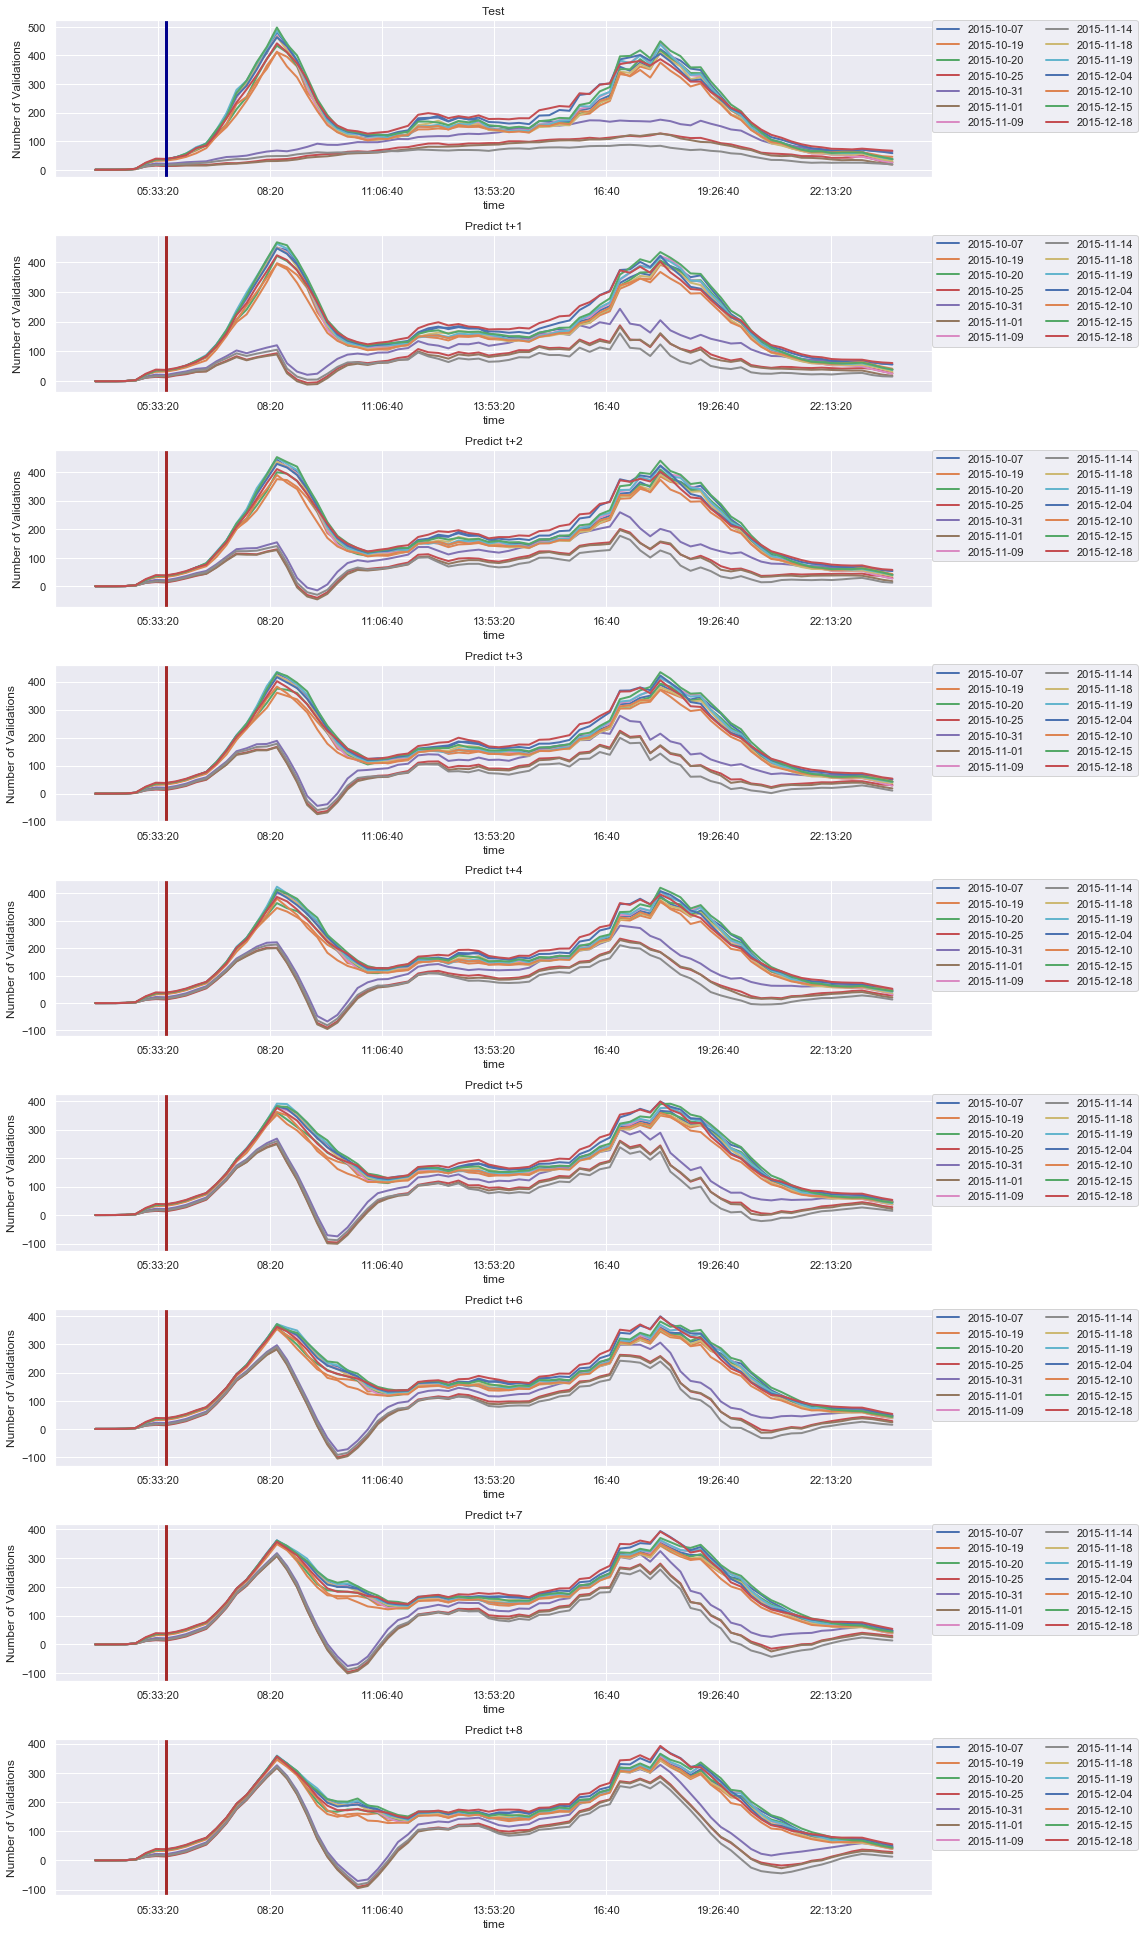

In [81]:
plot_qualitative_analysis(X_test, arbs_preds, p=arbs_order)

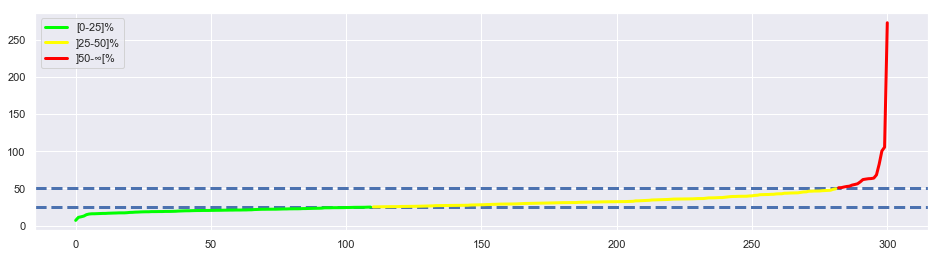

In [82]:
mape_firstt = mape_stations(X_test, arbs_preds[0], p=arbs_order)
clustering_mape_line(dict(zip(subway_stations, mape_firstt)), intervals=[25,50])

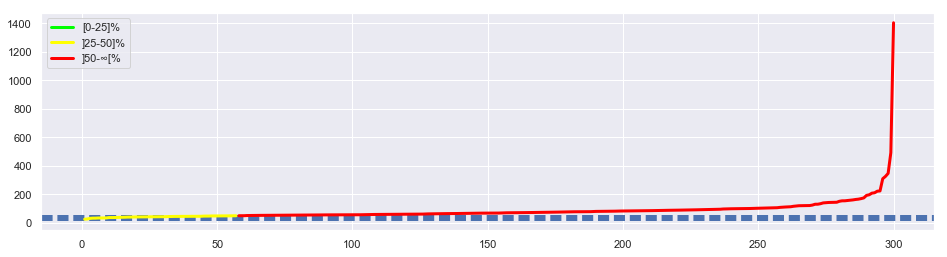

In [83]:
mape_lastt = mape_stations(X_test, arbs_preds[-1], p=arbs_order)
clustering_mape_line(dict(zip(subway_stations, mape_lastt)), intervals=[25, 50])

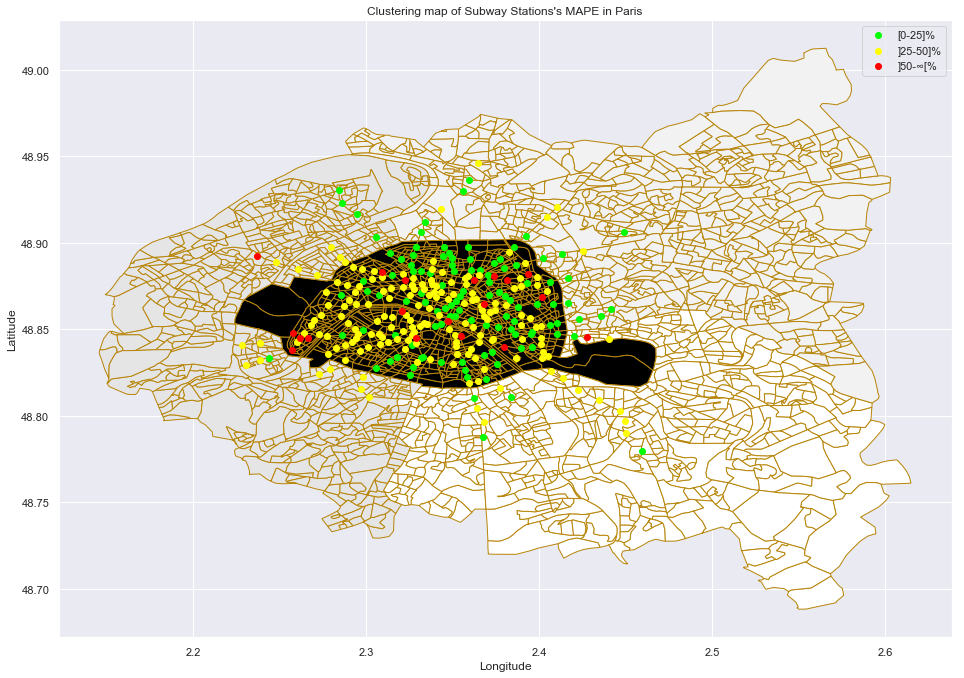

In [84]:
clustering_mape_map(contour_iris, station_data, dict(zip(subway_stations, mape_firstt)), 
                    intervals=[25, 50])

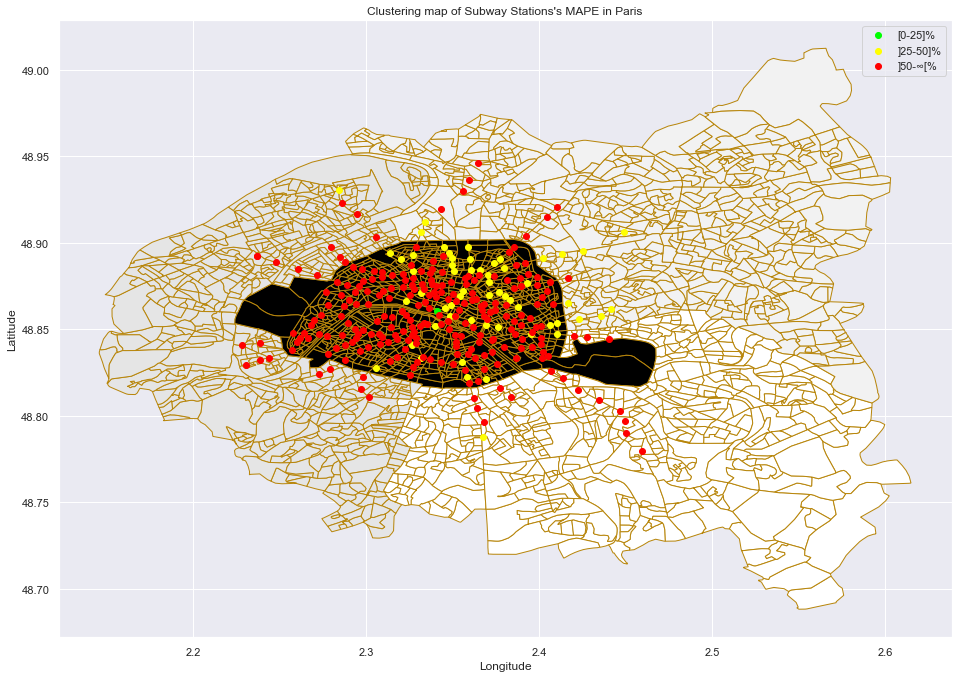

In [85]:
clustering_mape_map(contour_iris, station_data, dict(zip(subway_stations, mape_lastt)), 
                    intervals=[25, 50])

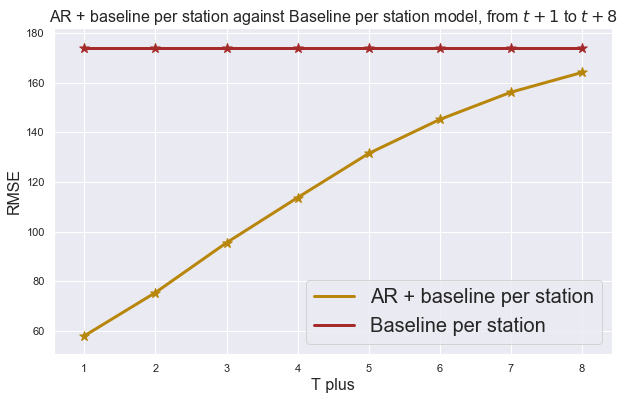

In [86]:
ar_against_baseline(arbs_scores, df_baseline_scores.loc['RMSE', 's'],
                   labels=['AR + baseline per station', 'Baseline per station'],
                   title='AR + baseline per station against Baseline per station model')

### Baseline per Station per day

In [87]:
Xbsj_train = sub_bsline_sj(X_train, X_train)
Xbsj_test = sub_bsline_sj(X_train, X_test)

Xbsjn_train, Xbsjn_test, Xbsj_min_max = normalize_panel_data(Xbsj_train, Xbsj_test)

In [88]:
arbsj_order, arbsj_limit_t = 8, 8
arbsj_reg = LinearRegression(fit_intercept=True)
arbsj_model = AR(p=arbsj_order, model=arbsj_reg)

arbsj_preds = fit_predict(arbsj_model, arbsj_limit_t, Xbsjn_train, Xbsjn_test, Xbsj_min_max)

for t in range(arbsj_limit_t):
    arbsj_preds[t] = add_bsline_sj(X_train, arbsj_preds[t])
    
arbsj_scores = arbsj_model.score(X_test, arbsj_preds)

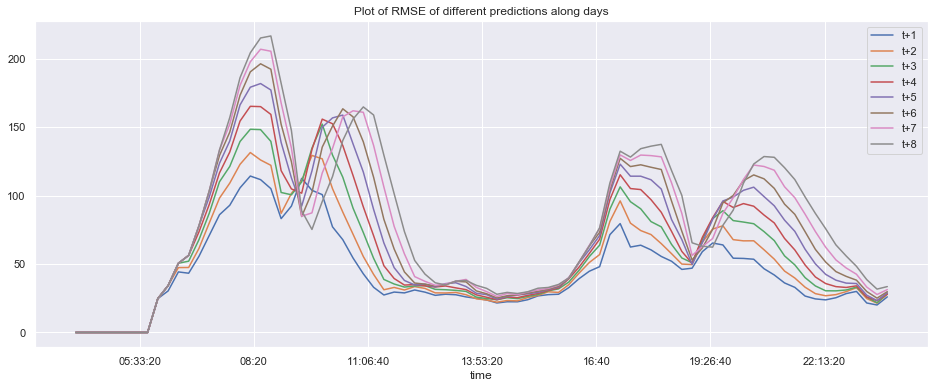

In [89]:
plot_diff_along_time(X_test, arbsj_preds)

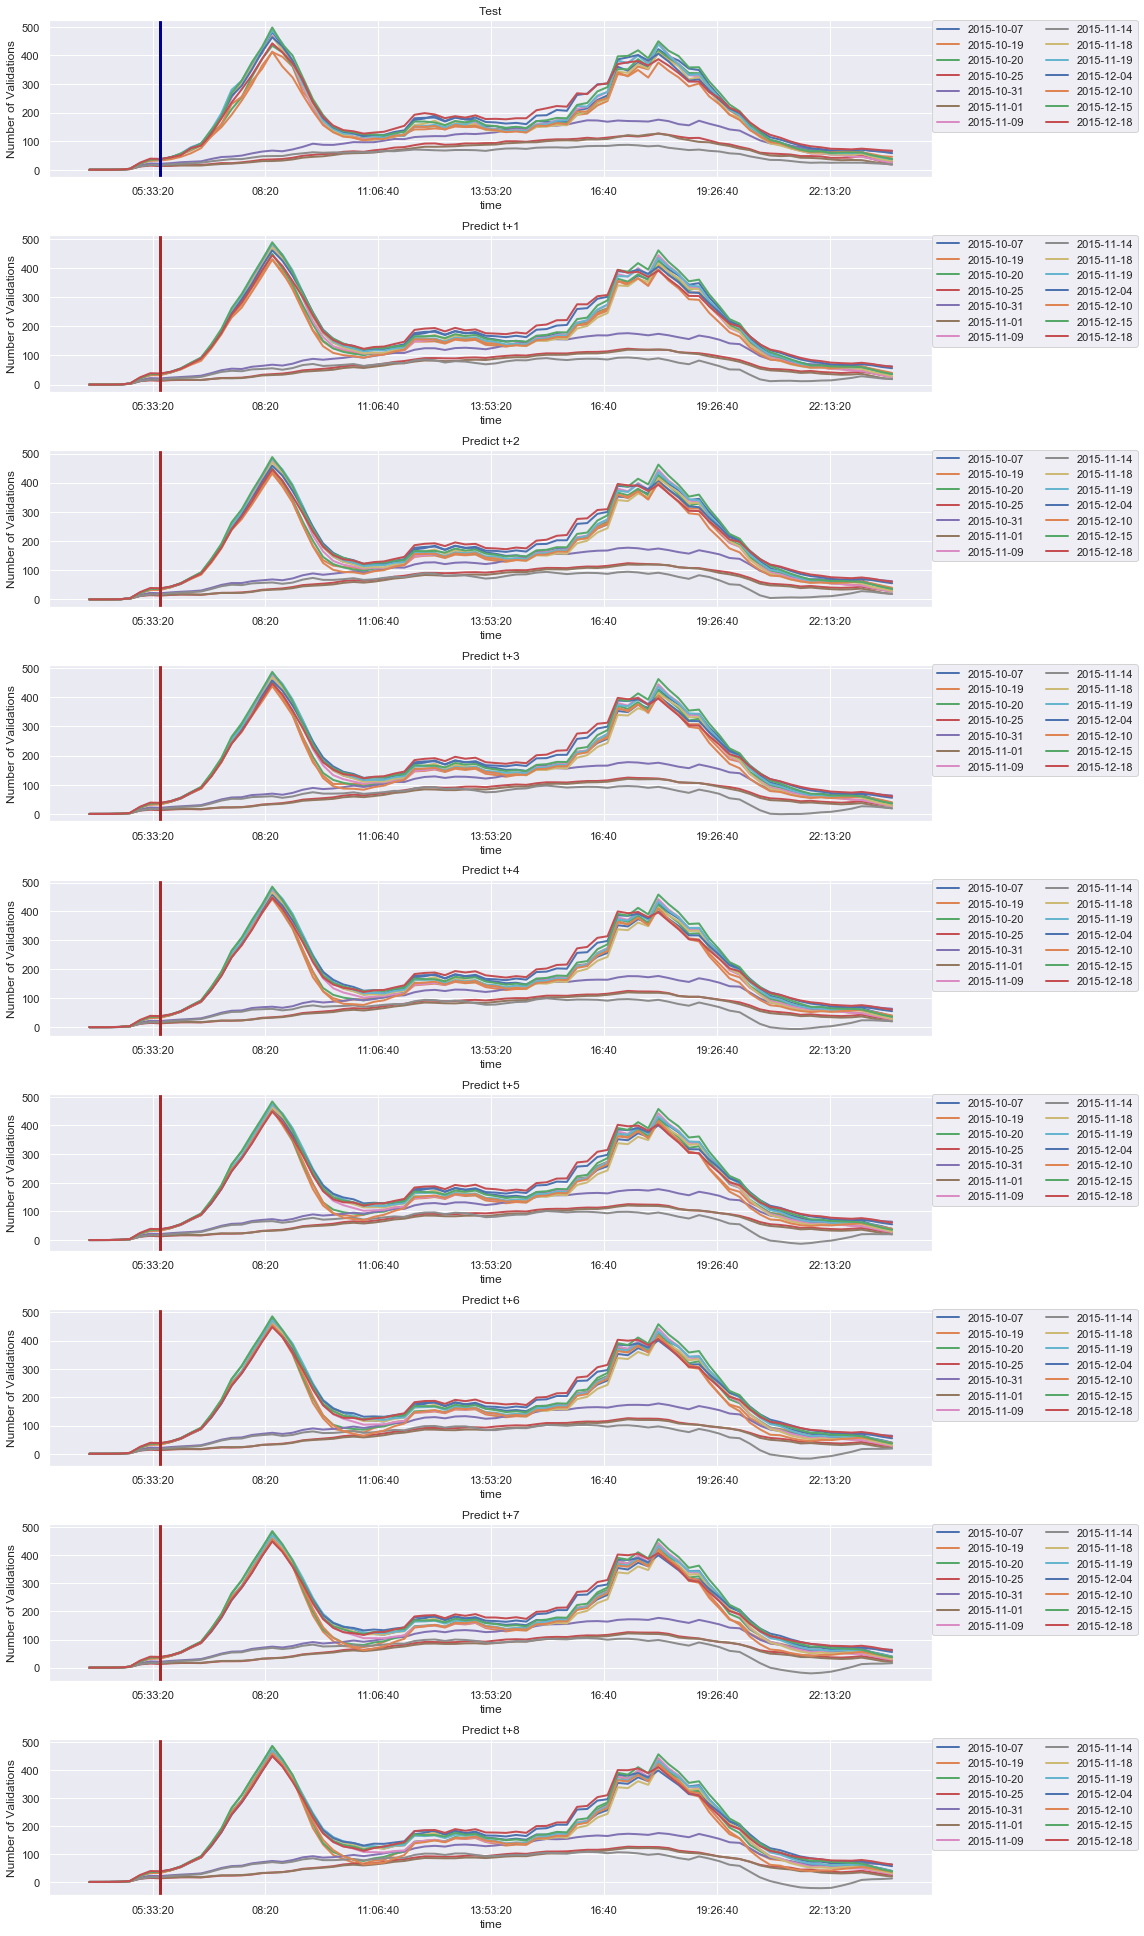

In [90]:
plot_qualitative_analysis(X_test, arbsj_preds, p=arbsj_order)

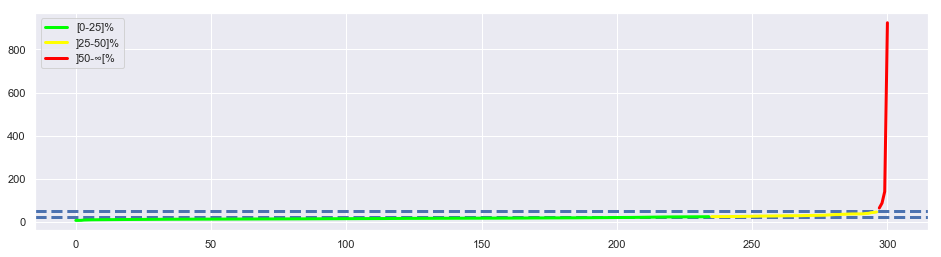

In [91]:
mape_firstt = mape_stations(X_test, arbsj_preds[0], p=arbsj_order)
clustering_mape_line(dict(zip(subway_stations, mape_firstt)), intervals=[25,50])

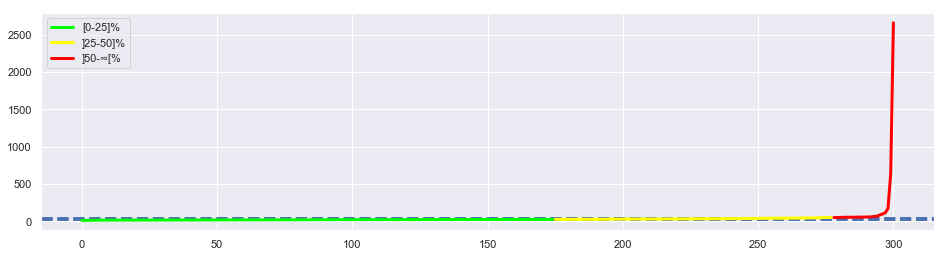

In [92]:
mape_lastt = mape_stations(X_test, arbsj_preds[-1], p=arbsj_order)
clustering_mape_line(dict(zip(subway_stations, mape_lastt)), intervals=[25, 50])

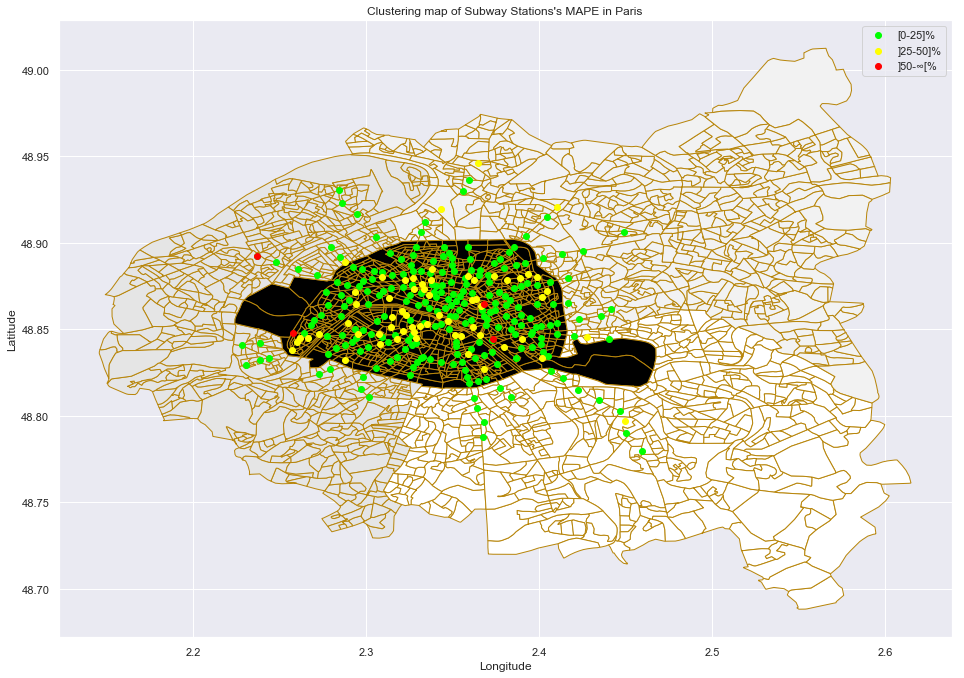

In [93]:
clustering_mape_map(contour_iris, station_data, dict(zip(subway_stations, mape_firstt)), 
                    intervals=[25, 50])

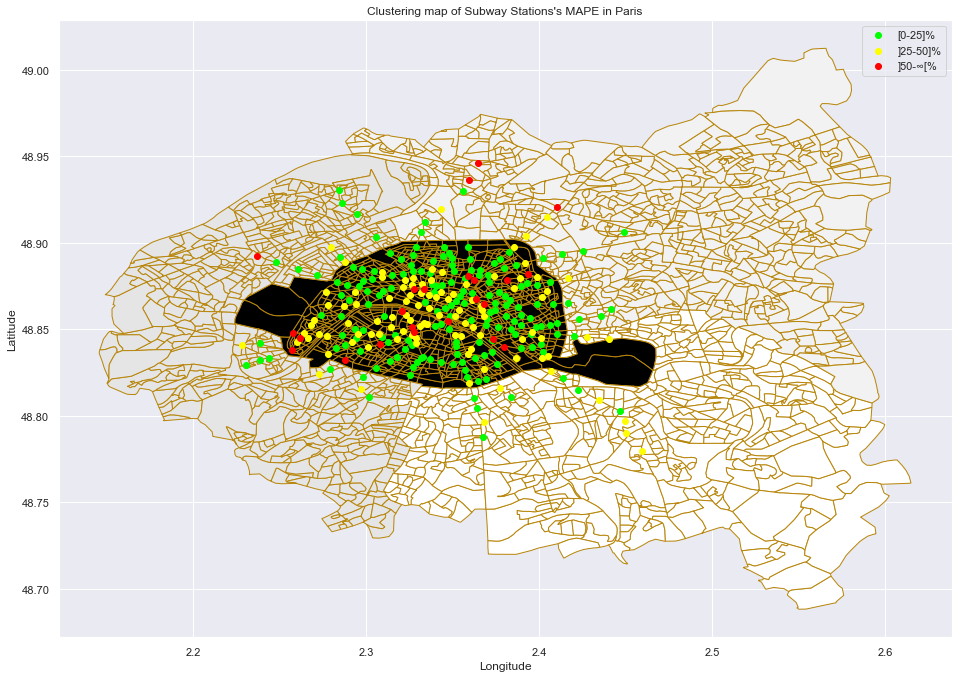

In [94]:
clustering_mape_map(contour_iris, station_data, dict(zip(subway_stations, mape_lastt)), 
                    intervals=[25, 50])

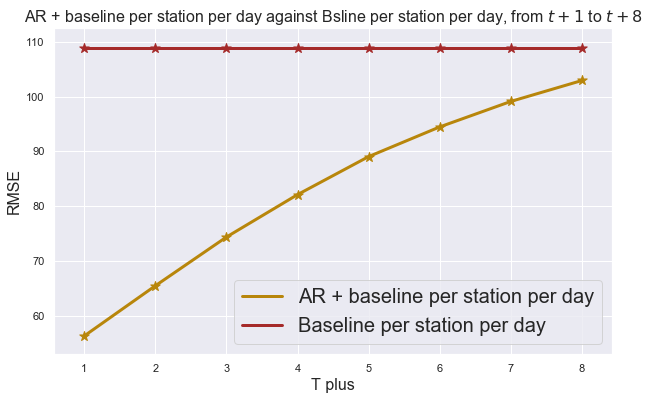

In [95]:
ar_against_baseline(arbsj_scores, df_baseline_scores.loc['RMSE', 'sj'],
                   labels=['AR + baseline per station per day', 
                           'Baseline per station per day'],
                   title='AR + baseline per station per day against Bsline per station per day')